# Make MTH5 from IRIS Data Managment Center v0.2.0 

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import MakeMTH5

from matplotlib import pyplot as plt
%matplotlib widget

2022-09-12 14:58:02,758 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


## Set the path to save files to as the current working directory

In [2]:
default_path = Path().cwd()

## Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [3]:
m = MakeMTH5(mth5_version='0.2.0')
m.client = "IRIS"

## Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

In [4]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
CAS04 = ["8P", "CAS04",  '2020-06-02T19:00:00', '2020-07-13T19:00:00'] 
NVR08 = ["8P", "NVR08", '2020-06-02T19:00:00', '2020-07-13T19:00:00']

request_list = []
for entry in [CAS04, NVR08]:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=m.column_names) 
request_df

,network,station,location,channel,start,end
0,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
5,8P,NVR08,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
6,8P,NVR08,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
7,8P,NVR08,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
8,8P,NVR08,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
9,8P,NVR08,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00


## Save the request as a CSV

Its helpful to be able to save the request as a CSV and modify it and use it later.  A CSV can be input as a request to `MakeMTH5`

In [5]:
request_df.to_csv(default_path.joinpath("fdsn_request.csv"))

## Get only the metadata from IRIS

It can be helpful to make sure that your request is what you would expect.  For that you can request only the metadata from IRIS.  The request is quick and light so shouldn't need to worry about the speed.  This returns a StationXML file and is loaded into an `obspy.Inventory` object.

In [6]:
inventory, data = m.get_inventory_from_df(request_df, data=False)

Have a look at the Inventory to make sure it contains what is requested.

In [7]:
inventory

Inventory created at 2022-09-12T21:58:04.624618Z
	Created by: ObsPy 1.3.0
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (2):
			8P.CAS04 (Corral Hollow, CA, USA)
			8P.NVR08 (Rhodes Salt Marsh, NV, USA)
		Channels (13):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN (2x), 
			8P.CAS04..LQE (3x), 8P.NVR08..LFZ, 8P.NVR08..LFN, 8P.NVR08..LFE, 
			8P.NVR08..LQN, 8P.NVR08..LQE

## Make an MTH5 from a request

Now that we've created a request, and made sure that its what we expect, we can make an MTH5 file.  The input can be either the DataFrame or the CSV file.  

We are going to time it just to get an indication how long it might take.  Should take about 4 minutes.

**Note:** we are setting `interact=False`.  If you want to just to keep the file open to interogat it set `interact=True`. 

In [8]:
%%time

mth5_object = m.make_mth5_from_fdsnclient(request_df, interact=False)

print(f"Created {mth5_object}")

2022-09-12 14:58:05,412 [line 605] mth5.mth5.MTH5.open_mth5 - WARNING: 8P_CAS04_NVR08.h5 will be overwritten in 'w' mode
2022-09-12 14:58:05,816 [line 672] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\docs\examples\notebooks\8P_CAS04_NVR08.h5 in mode w
2022-09-12 14:58:19,718 [line 120] mt_metadata.base.metadata.station.add_run - WARNING: Run a is being overwritten with current information


2022-09-12T14:58:19 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-12T14:58:19 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - IN

2022-09-12 14:58:20,705 [line 120] mt_metadata.base.metadata.station.add_run - WARNING: Run a is being overwritten with current information


2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-12T14:58:20 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_94.000 to a CoefficientFilter
2022-09-12T14:58:21 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-09-12T14:58:21 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_94.000 to a CoefficientFilter


2022-09-12 14:58:23,977 [line 784] mth5.groups.base.Station.add_run - INFO: run a already exists, returning existing group.
2022-09-12 14:58:24,358 [line 272] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2020-06-02T19:00:00+00:00 does not match metadata start 2020-06-02T18:41:43+00:00 updating metatdata value to 2020-06-02T19:00:00+00:00
2022-09-12 14:58:24,366 [line 286] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-06-02T22:07:47+00:00 does not match metadata end 2020-06-02T22:07:46+00:00 updating metatdata value to 2020-06-02T22:07:47+00:00
2022-09-12 14:58:35,443 [line 784] mth5.groups.base.Station.add_run - INFO: run b already exists, returning existing group.
2022-09-12 14:58:35,937 [line 286] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-06-12T17:52:24+00:00 does not match metadata end 2020-06-12T17:52:23+00:00 updating metatdata value to 2020-06-12T17:52:24+00:00
2022-09

Created C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\docs\examples\notebooks\8P_CAS04_NVR08.h5
Wall time: 1min 49s


In [ ]:
# open file already created
mth5_object = MTH5()
mth5_object.open_mth5("8P_CAS04_NVR08.h5")

## Have a look at the contents of the created file

In [10]:
mth5_object

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: CONUS_South
            ---------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: electric_analog_to_digital
                        ------------------------------------
                        |- Group: electric_dipole_92.000
                        --------------------------------
                        |- Group: electric_dipole_94.000
                        --------------------------------
                        |- Group: electric_si_units
                        ---------------------------
                        |- Group: magnetic_an

## Channel Summary

A convenience table is supplied with an MTH5 file.  This table provides some information about each channel that is present in the file.  It also provides columns `hdf5_reference`, `run_hdf5_reference`, and `station_hdf5_reference`, these are internal references within an HDF5 file and can be used to directly access a group or dataset by using `mth5_object.from_reference` method.  

**Note:** When a MTH5 file is close the table is resummarized so when you open the file next the `channel_summary` will be up to date. Same with the `tf_summary`.

In [11]:
mth5_object.channel_summary.clear_table()
mth5_object.channel_summary.summarize()

ch_df = mth5_object.channel_summary.to_dataframe()
ch_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:47+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:47+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:47+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:47+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:47+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:24+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:24+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:24+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:24+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS South,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:24+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Have a look at a station

Lets grab one station `CAS04` and have a look at its metadata and contents.
Here we will grab it from the `mth5_object`.

In [12]:
cas04 = mth5_object.get_station("CAS04", survey="CONUS_South")
cas04.metadata

{
    "station": {
        "acquired_by.name": null,
        "channels_recorded": [],
        "data_type": "MT",
        "fdsn.id": "CAS04",
        "geographic_name": "Corral Hollow, CA, USA",
        "hdf5_reference": "<HDF5 object reference>",
        "id": "CAS04",
        "location.declination.comments": "igrf.m by Drew Compston",
        "location.declination.model": "IGRF-13",
        "location.declination.value": 13.1745887285666,
        "location.elevation": 329.3875,
        "location.latitude": 37.633351,
        "location.longitude": -121.468382,
        "mth5_type": "Station",
        "orientation.method": "compass",
        "orientation.reference_frame": "geographic",
        "provenance.creation_time": "1980-01-01T00:00:00+00:00",
        "provenance.software.author": "Anna Kelbert, USGS",
        "provenance.software.name": "mth5_metadata.m",
        "provenance.software.version": "2022-03-31",
        "provenance.submitter.email": null,
        "provenance.submitter.o

### Changing Metadata
If you want to change the metadata of any group, be sure to use the `write_metadata` method.  Here's an example:

In [13]:
cas04.metadata.location.declination.value = -13.5
cas04.write_metadata()
print(cas04.metadata.location.declination)

declination:
	comments = igrf.m by Drew Compston
	model = IGRF-13
	value = -13.5


## Have a look at a single channel

Let's pick out a channel and interogate it. There are a couple ways
1. Get a channel the first will be from the `hdf5_reference` [*demonstrated here*]
2. Get a channel from `mth5_object`
3. Get a station first then get a channel


In [14]:
ex = mth5_object.from_reference(ch_df.iloc[0].hdf5_reference).to_channel_ts()
print(ex)

Channel Summary:
	Station:      CAS04
	Run:          a
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-06-02T19:00:00+00:00
	End:          2020-06-02T22:07:47+00:00
	N Samples:    11267


In [15]:
ex.channel_metadata

{
    "electric": {
        "channel_number": 0,
        "comments": "run_ids: [c,b,a]",
        "component": "ex",
        "data_quality.rating.value": 0,
        "dipole_length": 92.0,
        "filter.applied": [
            false
        ],
        "filter.name": [
            "electric_si_units",
            "electric_dipole_92.000",
            "electric_butterworth_low_pass",
            "electric_butterworth_high_pass",
            "electric_analog_to_digital",
            "electric_time_offset"
        ],
        "hdf5_reference": "<HDF5 object reference>",
        "measurement_azimuth": 13.2,
        "measurement_tilt": 0.0,
        "mth5_type": "Electric",
        "negative.elevation": 329.4,
        "negative.id": "200406D",
        "negative.latitude": 37.633351,
        "negative.longitude": -121.468382,
        "negative.manufacturer": "Oregon State University",
        "negative.model": "Pb-PbCl2 kaolin gel Petiau 2 chamber type",
        "negative.type": "electrode",
  

## Calibrate time series data
Most data loggers output data in digital counts.  Then a series of filters that represent the various instrument responses are applied to get the data into physical units.  The data can then be analyzed and processed. Commonly this is done during the processing step, but it is important to be able to look at time series data in physical units.  Here we provide a `remove_instrument_response` method in the `ChananelTS` object.  Here's an example:  

Filters Included:
coefficient_filter:
	calibration_date = 1980-01-01
	comments = practical to SI unit conversion
	gain = 1e-06
	name = electric_si_units
	type = coefficient
	units_in = mV/km
	units_out = V/m
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = electric dipole for electric field
	gain = 92.0
	name = electric_dipole_92.000
	type = coefficient
	units_in = V/m
	units_out = V
--------------------
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = NIMS electric field 5 pole Butterworth 0.5 low pass (analog)
	gain = 1.0
	name = electric_butterworth_low_pass
	normalization_factor = 313383.493219835
	poles = [ -3.883009+11.951875j  -3.883009-11.951875j -10.166194 +7.386513j
 -10.166194 -7.386513j -12.566371 +0.j      ]
	type = zpk
	units_in = V
	units_out = V
	zeros = []
--------------------
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = NIMS electric field 1 pole Butterworth high pass (analog)
	gain = 1.0
	name = electric_

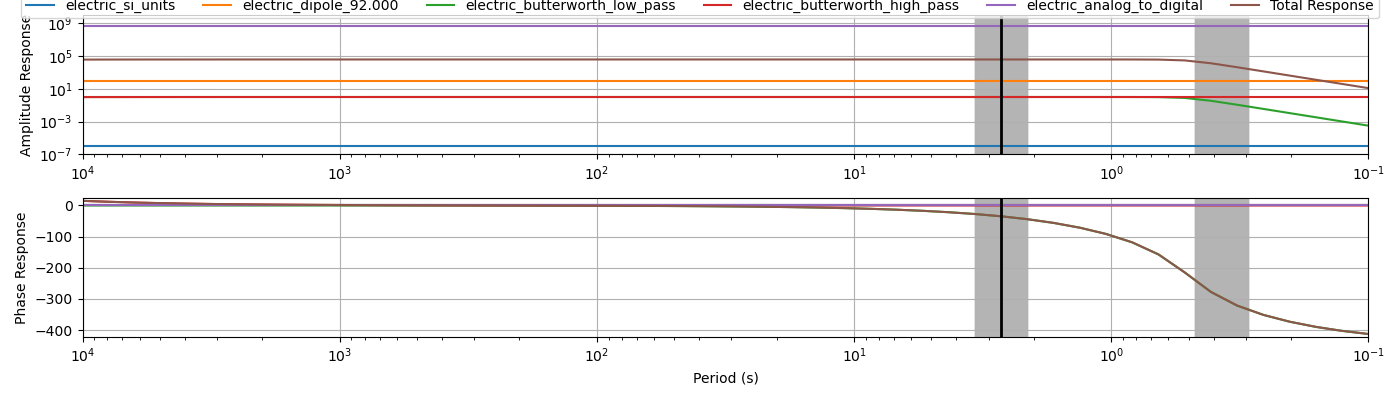

In [16]:
print(ex.channel_response_filter)
ex.channel_response_filter.plot_response(np.logspace(-4, 1, 50))

C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\timeseries\ts_filters.py:500: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim((f[0], f[-1]))


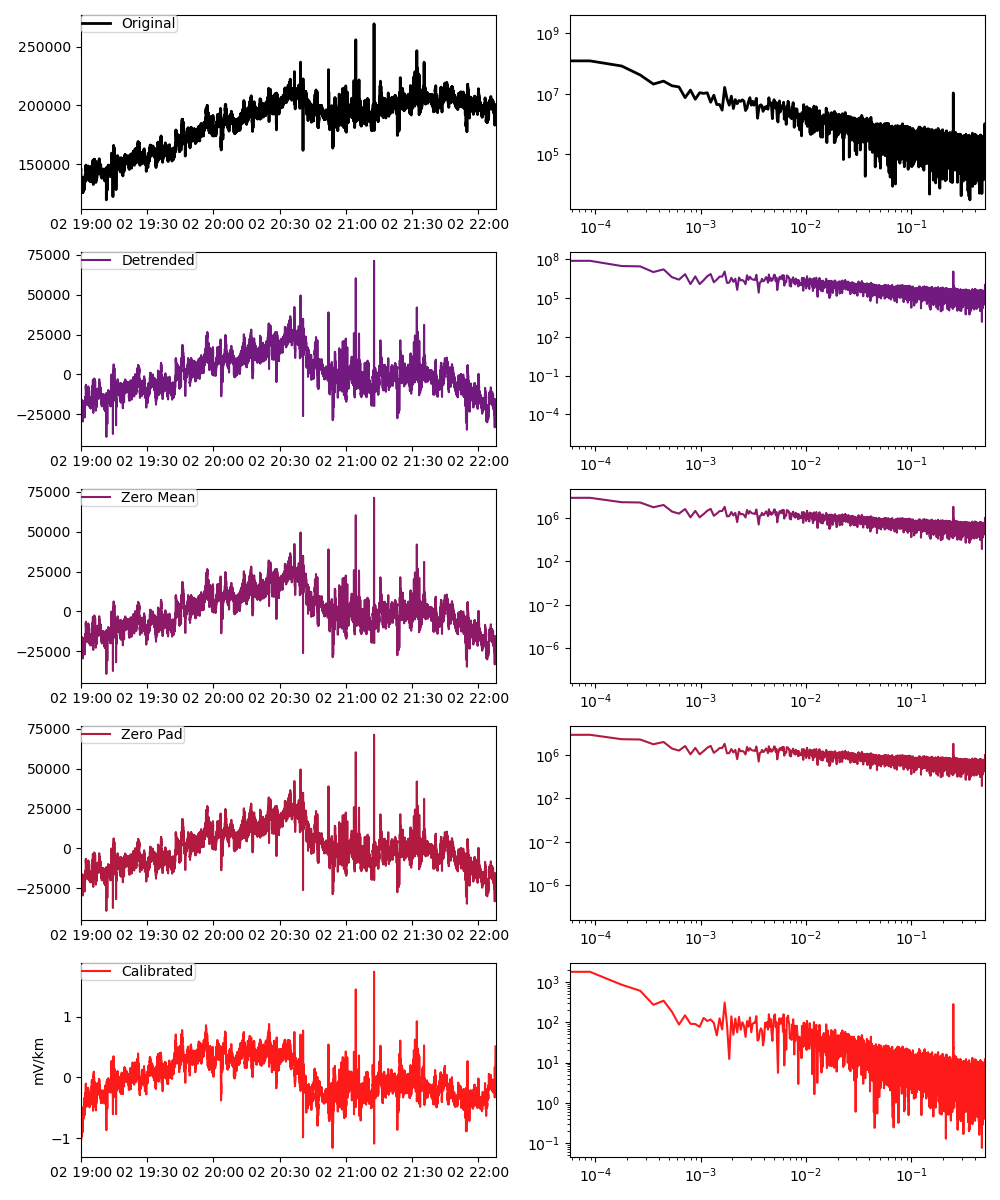

Channel Summary:
	Station:      CAS04
	Run:          a
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-06-02T19:00:00+00:00
	End:          2020-06-02T22:07:47+00:00
	N Samples:    11267

In [17]:
ex.remove_instrument_response(plot=True)

## Have a look at a run

Let's pick out a run, take a slice of it, and interogate it. There are a couple ways
1. Get a run the first will be from the `run_hdf5_reference` [*demonstrated here*]
2. Get a run from `mth5_object`
3. Get a station first then get a run

In [18]:
run_from_reference = mth5_object.from_reference(ch_df.iloc[0].run_hdf5_reference).to_runts(start=ch_df.iloc[0].start.isoformat(), n_samples=360)
print(run_from_reference)

RunTS Summary:
	Station:     CAS04
	Run:         a
	Start:       2020-06-02T19:00:00+00:00
	End:         2020-06-02T19:06:01+00:00
	Sample Rate: 1.0
	Components:  ['ex', 'ey', 'hx', 'hy', 'hz']


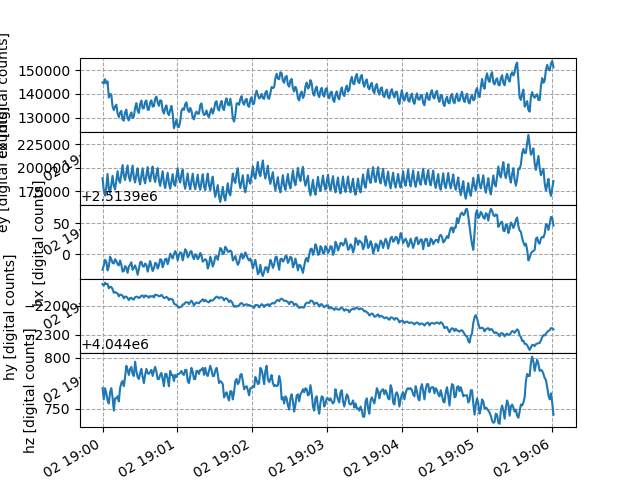

In [19]:
run_from_reference.plot()

### Calibrate Run

2022-09-12 15:00:09,287 [line 286] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-06-02T19:06:01+00:00 does not match metadata end 2020-06-02T22:07:47+00:00 updating metatdata value to 2020-06-02T19:06:01+00:00


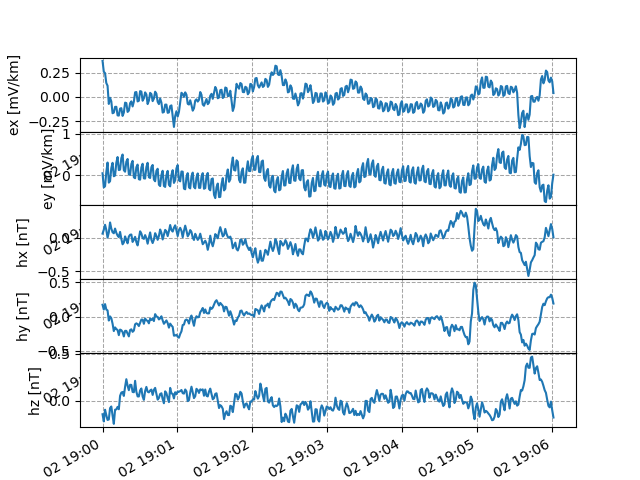

In [20]:
calibrated_run = run_from_reference.calibrate()
calibrated_run.plot()

## Load Transfer Functions

You can download the transfer functions for **CAS04** and **NVR08** from [IRIS SPUD EMTF](http://ds.iris.edu/spud/emtf).  This has already been done as EMTF XML format and will be loaded here. 

In [21]:
cas04_tf = r"USMTArray.CAS04.2020.xml"
nvr08_tf = r"USMTArray.NVR08.2020.xml"

In [22]:
from mt_metadata.transfer_functions.core import TF

In [23]:
for tf_fn in [cas04_tf, nvr08_tf]:
    tf_obj = TF(tf_fn)
    tf_obj.read_tf_file()
    mth5_object.add_transfer_function(tf_obj)

### Have a look at the transfer function summary

In [24]:
mth5_object.tf_summary.summarize()
tf_df = mth5_object.tf_summary.to_dataframe()
tf_df

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,CAS04,CONUS_South,37.633351,-121.468382,329.387,CAS04,none,True,True,True,4.65455,29127.11,<HDF5 object reference>,<HDF5 object reference>
1,NVR08,CONUS_South,38.326630,-118.082382,1375.425,NVR08,none,True,True,True,4.65455,29127.11,<HDF5 object reference>,<HDF5 object reference>


### Plot the transfer functions using MTpy

**Note:** This currently works on branch `mtpy/v2_plots`

In [25]:
from mtpy import MTCollection

2022-09-12T15:00:16 [line 121] mtpy.utils.mtpy_decorator._check_gdal_data - INFO: GDAL_DATA is set to: C:\Users\jpeacock\Anaconda3\envs\em\Library\share\gdal


2022-09-12 15:00:16,746 [line 133] matplotlib.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\logs\matplotlib_warn.log


ImportError: cannot import name 'MTCollection' from 'mtpy' (C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\mtpy\__init__.py)

In [ ]:
mc = MTCollection()
mc.open_collection(r"8P_CAS04_NVR08")

In [ ]:
pmr = mc.plot_mt_response(["CAS04", "NVR08"], plot_style="1")

## Plot Station locations

Here we can plot station locations for all stations in the file, or we can give it a bounding box.  If you have internet access a basemap will be plotted using [Contextily](https://contextily.readthedocs.io/en/latest/). 

In [ ]:
st = mc.plot_stations(pad=.9, fig_num=5, fig_size=[6, 4])

In [ ]:
st.fig.get_axes()[0].set_xlim((-121.9, -117.75))
st.fig.get_axes()[0].set_ylim((37.35, 38.5))
st.update_plot()

In [ ]:
mth5_object.close_mth5()